In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
import pickle
import pathlib

In [56]:
# load data
df = pd.read_csv("eda_data.csv")
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,...,age,python_yn,R_yn,spark,aws,excel,job_simp,seniority,desc_len,num_comp
0,0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,...,47,1,0,0,0,1,data scientist,na,2536,0
1,1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,...,36,1,0,0,0,0,data scientist,na,4783,0
2,2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information sec...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,...,10,1,0,1,0,1,data scientist,na,3461,0
3,3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\n...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,...,55,1,0,0,0,0,data scientist,na,3883,3
4,4,Data Scientist,$86K-$143K (Glassdoor est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,...,22,1,0,0,0,1,data scientist,na,2728,3


In [57]:
df.columns

Index(['Unnamed: 0', 'Job Title', 'Salary Estimate', 'Job Description',
       'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded',
       'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors',
       'hourly', 'employer_provided', 'min_salary', 'max_salary', 'avg_salary',
       'company_txt', 'job_state', 'same_state', 'age', 'python_yn', 'R_yn',
       'spark', 'aws', 'excel', 'job_simp', 'seniority', 'desc_len',
       'num_comp'],
      dtype='object')

In [58]:
# select only relevant features 
cols = [
    "avg_salary", "Rating", "Size", "Type of ownership", "Industry", "Sector",
    "Revenue", "num_comp", "hourly", "employer_provided", "job_state",
    "same_state", "age", "python_yn", "spark", "aws", "excel", "job_simp",
    "seniority", "desc_len",
]
df_model = df[cols]

In [59]:
# one-hot encode categorical columns
df_dum = pd.get_dummies(df_model, drop_first=True)

In [60]:
# create X, y for training dataset
# X will hold the dataset without the avg_salary columm
X = df_dum.drop("avg_salary", axis=1)
X.head()

,Rating,num_comp,hourly,employer_provided,same_state,age,python_yn,spark,aws,excel,...,job_state_WA,job_state_WI,job_simp_data engineer,job_simp_data scientist,job_simp_director,job_simp_manager,job_simp_mle,job_simp_na,seniority_na,seniority_senior
0,3.8,0,0,0,0,47,1,0,0,1,...,False,False,False,True,False,False,False,False,True,False
1,3.4,0,0,0,0,36,1,0,0,0,...,False,False,False,True,False,False,False,False,True,False
2,4.8,0,0,0,1,10,1,1,0,1,...,False,False,False,True,False,False,False,False,True,False
3,3.8,3,0,0,1,55,1,0,0,0,...,True,False,False,True,False,False,False,False,True,False
4,2.9,3,0,0,1,22,1,0,0,1,...,False,False,False,True,False,False,False,False,True,False


In [61]:
# y will hold the dropped column
y = df_dum['avg_salary']
y

0       72.0
1       87.5
2       85.0
3       76.5
4      114.5
       ...  
737     84.5
738    102.5
739     73.5
740    127.5
741     93.5
Name: avg_salary, Length: 742, dtype: float64

In [62]:
# split into train/test datasets
# only 20% of data goes into training dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [63]:
# MAE scorer helper
pos_mae = make_scorer(mean_absolute_error, greater_is_better=False)

def cv_mae(model):
    """Return +MAE (so ‘lower is better’ is obvious)."""
    scores = cross_val_score(model, X_train, y_train, scoring=pos_mae, cv=5)
    return -scores.mean()

In [64]:
# add a 'const' column for intercept term
drop_list = ['spark','aws','excel','num_comp','employer_provided','same_state','python_yn','hourly','num_comp']
X_sm = X.drop(columns=drop_list, axis=1)
X_sm.head()

,Rating,age,desc_len,Size_1 to 50 employees,Size_10000+ employees,Size_1001 to 5000 employees,Size_201 to 500 employees,Size_5001 to 10000 employees,Size_501 to 1000 employees,Size_51 to 200 employees,...,job_state_WA,job_state_WI,job_simp_data engineer,job_simp_data scientist,job_simp_director,job_simp_manager,job_simp_mle,job_simp_na,seniority_na,seniority_senior
0,3.8,47,2536,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
1,3.4,36,4783,False,True,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,4.8,10,3461,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
3,3.8,55,3883,False,False,True,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4,2.9,22,2728,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False


In [65]:
# ─── (1) OLS for quick interpretability ──────────────────────────────────────
X_sm = sm.add_constant(X_sm.select_dtypes(include=[np.number]))
print("📊 statsmodels OLS …")
ols_res = sm.OLS(y.astype(float), X_sm, missing='raise').fit()
print(ols_res.summary())

📊 statsmodels OLS …
                            OLS Regression Results                            
Dep. Variable:             avg_salary   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.600
Date:                Sun, 18 May 2025   Prob (F-statistic):              0.188
Time:                        22:19:44   Log-Likelihood:                -3765.6
No. Observations:                 742   AIC:                             7539.
Df Residuals:                     738   BIC:                             7558.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         90.1952      7.581

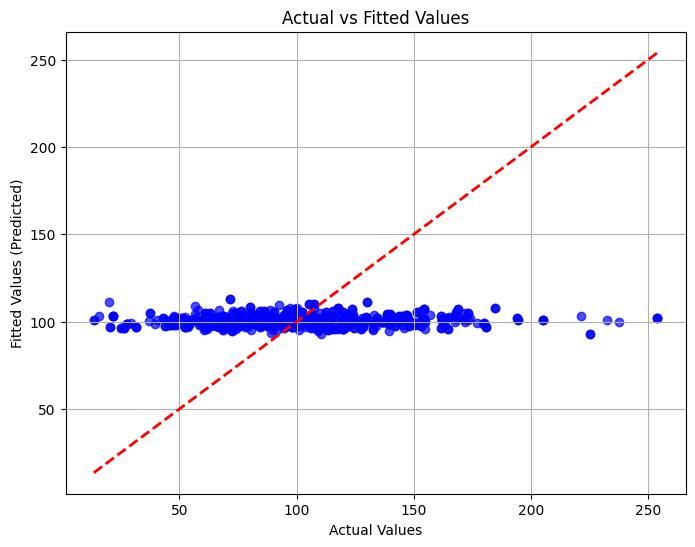

In [66]:
# Plot the fitted values against the actual data points
plt.figure(figsize=(8, 6))
plt.scatter(y, ols_res.fittedvalues, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)  # Line of perfect fit
plt.xlabel("Actual Values")
plt.ylabel("Fitted Values (Predicted)")
plt.title("Actual vs Fitted Values")
plt.grid(True)
plt.show()

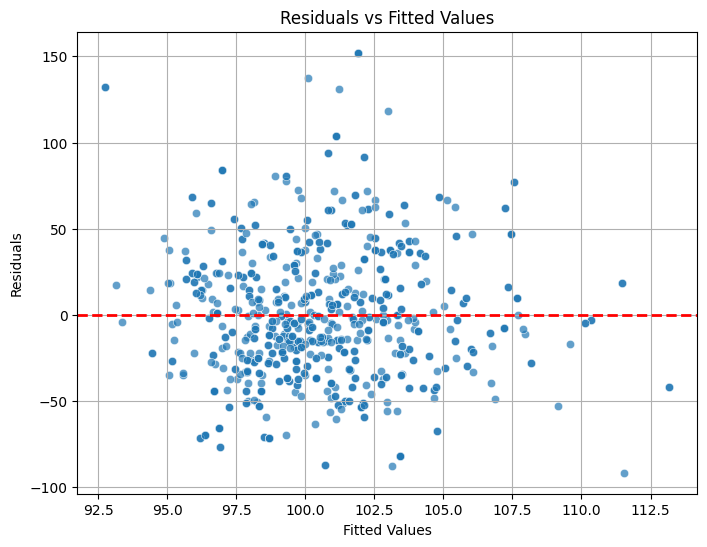

In [67]:
# Residuals vs Fitted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=ols_res.fittedvalues, y=ols_res.resid, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.grid(True)
plt.show()

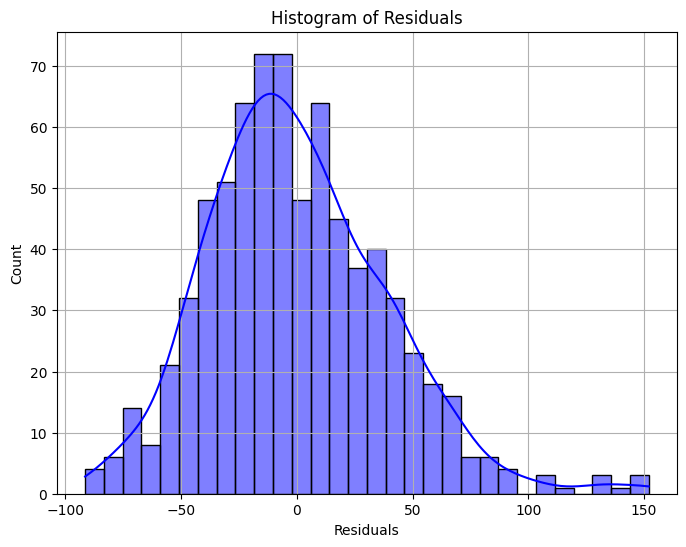

In [68]:
# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(ols_res.resid, kde=True, bins=30, color='blue')
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

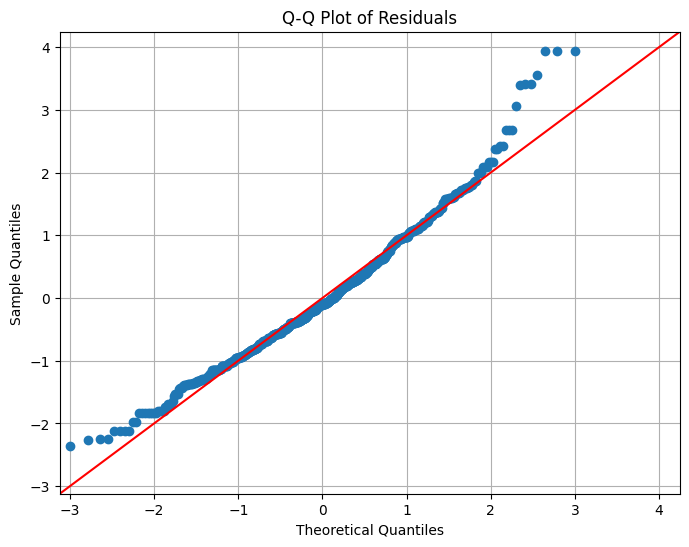

In [69]:
# Q-Q Plot of Residuals
fig, ax = plt.subplots(figsize=(8, 6))
sm.qqplot(ols_res.resid, line='45', fit=True, ax=ax)
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

In [70]:
# ─── (2) Linear Regression ───────────────────────────────────────────────────
print("📈 Linear Regression (sklearn)…")
lm = LinearRegression()
lm_mae = cv_mae(lm)
print(f"✅ CV MAE: {lm_mae:0.2f}k USD")

📈 Linear Regression (sklearn)…
✅ CV MAE: 19.28k USD


📉 Lasso Regression …
🏆 Best alpha = 0.02 (CV MAE 19.01k)


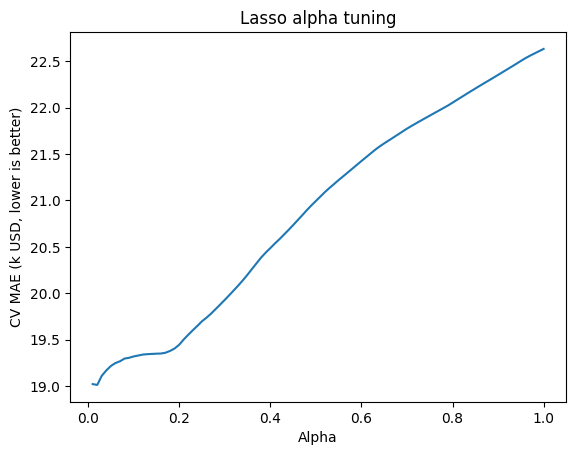

In [71]:
# ─── (3) Lasso Regression + alpha scan ───────────────────────────────────────
print("📉 Lasso Regression …")
alphas, mae_vals = [], []

for a in np.linspace(0.01, 1.0, 100):
    lml = Lasso(alpha=a, max_iter=10_000)
    mae_vals.append(cv_mae(lml))
    alphas.append(a)

best_alpha = alphas[int(np.argmin(mae_vals))]
print(f"🏆 Best alpha = {best_alpha:.2f} (CV MAE {min(mae_vals):.2f}k)")

# Plot for reference
plt.figure()
plt.plot(alphas, mae_vals)
plt.xlabel("Alpha")
plt.ylabel("CV MAE (k USD, lower is better)")
plt.title("Lasso alpha tuning")
plt.show()

In [72]:
print("Lasso Coefficients:")
print(lasso_best.coef_.shape)
# Get the coefficients from the Lasso model
lasso_coefficients = pd.Series(lasso_best.coef_, index=X_train.columns)

# Features eliminated by Lasso (coefficients set to zero)
eliminated_features = lasso_coefficients[lasso_coefficients == 0].index.tolist()
print("Features eliminated by Lasso:")
print(eliminated_features)

# Features retained by Lasso (non-zero coefficients)
retained_features = lasso_coefficients[lasso_coefficients != 0].index.tolist()
print("\nFeatures retained by Lasso:")
print(retained_features)

Lasso Coefficients:
(169,)
Features eliminated by Lasso:
['Size_1 to 50 employees', 'Type of ownership_College / University', 'Type of ownership_School / School District', 'Type of ownership_Unknown', 'Industry_Accounting', 'Industry_Auctions & Galleries', 'Industry_Computer Hardware & Software', 'Industry_Energy', 'Industry_Farm Support Services', 'Industry_Federal Agencies', 'Industry_Financial Transaction Processing', 'Industry_Health, Beauty, & Fitness', 'Industry_IT Services', 'Industry_Insurance Carriers', 'Industry_K-12 Education', 'Industry_Logistics & Supply Chain', 'Industry_Metals Brokers', 'Industry_Mining', 'Industry_Other Retail Stores', 'Industry_Telecommunications Manufacturing', 'Industry_Telecommunications Services', 'Industry_Wholesale', 'Sector_Accounting & Legal', 'Sector_Agriculture & Forestry', 'Sector_Business Services', 'Sector_Education', 'Sector_Government', 'Sector_Insurance', 'Sector_Non-Profit', 'Sector_Oil, Gas, Energy & Utilities', 'Sector_Real Estate', 

In [73]:
from sklearn.metrics import mean_squared_error, r2_score

# Predictions
y_train_pred = lasso_best.predict(X_train)
y_test_pred = lasso_best.predict(X_test)

# Metrics
print("Train MSE:", mean_absolute_error(y_train, y_train_pred))
print("Test MSE:", mean_absolute_error(y_test, y_test_pred))
print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_test_pred))

Train MSE: 15.182670859437996
Test MSE: 18.93061275770802
Train R²: 0.7086783830989468
Test R²: 0.6034699435039652


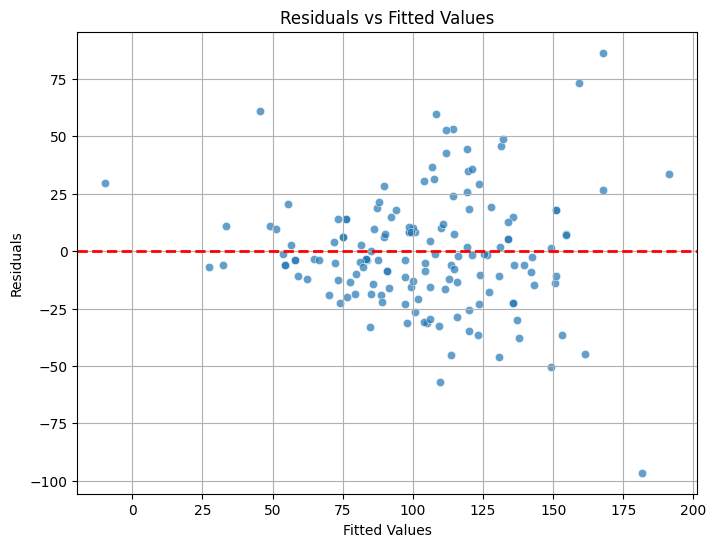

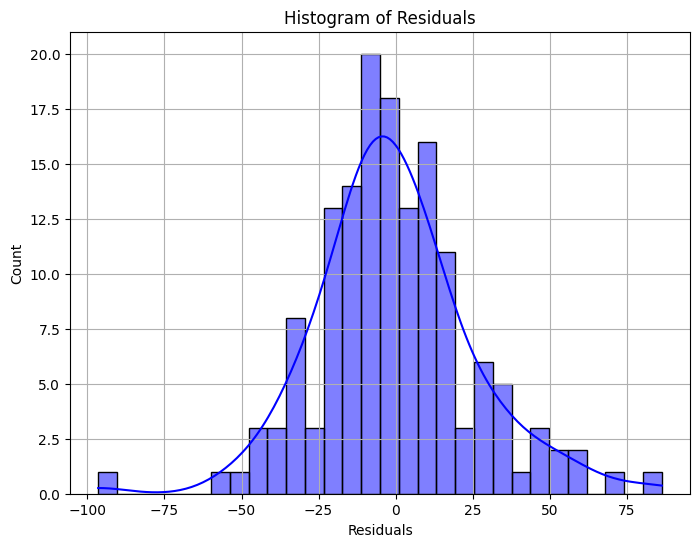

In [74]:
residuals = y_test - y_test_pred

# Residuals vs Fitted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_pred, y=residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.grid(True)
plt.show()

# Histogram of Residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.grid(True)
plt.show()

In [75]:
feature_importance = pd.Series(lasso_best.coef_, index=X_train.columns)
print("Feature Importance:")
print(feature_importance[feature_importance != 0].sort_values(ascending=False))

Feature Importance:
job_simp_director                                    90.068015
Industry_Brokerage Services                          75.724757
Industry_Motion Picture Production & Distribution    47.572335
job_simp_mle                                         44.873869
Industry_Investment Banking & Asset Management       44.580843
                                                       ...    
Industry_Sporting Goods Stores                      -26.566657
Type of ownership_Government                        -27.106087
job_state_NM                                        -27.501741
Industry_Construction                               -29.517522
hourly                                              -43.069504
Length: 126, dtype: float64


In [76]:
# Re‑fit best Lasso on full training data
lasso_best = Lasso(alpha=best_alpha, max_iter=10_000).fit(X_train, y_train)


In [77]:
# ─── (4) Random Forest + GridSearch ──────────────────────────────────────────
print("🌲 Random Forest …")
rf = RandomForestRegressor(random_state=42)

grid = {
    "n_estimators": range(40, 241, 40),
    "criterion": ["squared_error", "absolute_error"],
    "max_features": ["sqrt", "log2", None],        # ‘auto’ removed
}

print("🔍 GridSearchCV …")
gs = GridSearchCV(
    rf,
    grid,
    scoring=pos_mae,
    cv=5,
    n_jobs=-1,
    verbose=0,
)
gs.fit(X_train, y_train)
rf_best = gs.best_estimator_
print(f"🏆 Best RF → {rf_best}")
print(f"✅ Best CV MAE: {-gs.best_score_:0.2f}k USD")


🌲 Random Forest …
🔍 GridSearchCV …
🏆 Best RF → RandomForestRegressor(max_features=None, n_estimators=200, random_state=42)
✅ Best CV MAE: 13.85k USD


In [78]:
# ─── (5) Test‑set evaluation ─────────────────────────────────────────────────
print("\n🔬 Test‑set results")
for name, model in [
    ("Linear Regression", lm.fit(X_train, y_train)),
    ("Lasso",            lasso_best),
    ("Random Forest",    rf_best),
]:
    preds = model.predict(X_test)
    mae  = mean_absolute_error(y_test, preds)
    print(f"• {name}: MAE = {mae:0.2f}k USD")

# Simple ensemble (average of Linear & RF)
ensemble_pred = (lm.predict(X_test) + rf_best.predict(X_test)) / 2
ensemble_mae  = mean_absolute_error(y_test, ensemble_pred)
print(f"• Ensemble (Linear + RF): MAE = {ensemble_mae:0.2f}k USD")



🔬 Test‑set results
• Linear Regression: MAE = 18.84k USD
• Lasso: MAE = 18.93k USD
• Random Forest: MAE = 11.34k USD
• Ensemble (Linear + RF): MAE = 14.22k USD


In [79]:
# ─── (6) Persist best model ──────────────────────────────────────────────────
print("\n💾 Saving best model (Random Forest)…")
model_dir = pathlib.Path("FlaskAPI/models")
model_dir.mkdir(parents=True, exist_ok=True)

with open(model_dir / "model_file.p", "wb") as f:
    pickle.dump({"model": rf_best}, f)



💾 Saving best model (Random Forest)…


In [80]:

# ─── (7) Quick sanity check ──────────────────────────────────────────────────
sample = X_test.iloc[[0]]          # keep header to avoid warning
print("\n♻️ Reloading & predicting one sample…")
with open(model_dir / "model_file.p", "rb") as f:
    model = pickle.load(f)["model"]

print("📌 Predicted salary:", model.predict(sample)[0])
print("🧾 Features used:", list(sample.iloc[0]))

print("\n✅ Pipeline finished successfully.")



♻️ Reloading & predicting one sample…
📌 Predicted salary: 117.365
🧾 Features used: [np.float64(4.4), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(21), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(4188), np.False_, np.False_, np.False_, np.True_, np.False_, np.False_, np.False_, np.False_, np.False_, np.True_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.True_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False_, np.False